In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.utils import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [65]:
PANEL_supp_LP1 = "../svg/panel_supp_lp1.svg"
PANEL_supp_LP2 = "../svg/panel_supp_lp2.svg"
PANEL_supp_PY1 = "../svg/panel_supp_py1.svg"
PANEL_supp_PY2 = "../svg/panel_supp_py2.svg"

PANEL_supp_LP_EV1 = "../svg/panel_supp_lp_ev1.svg"
PANEL_supp_LP_EV2 = "../svg/panel_supp_lp_ev2.svg"
PANEL_supp_PY_EV1 = "../svg/panel_supp_py_ev1.svg"
PANEL_supp_PY_EV2 = "../svg/panel_supp_py_ev2.svg"

PANEL_supp_LP_syn1 = "../svg/panel_supp_lp_syn1.svg"
PANEL_supp_LP_syn2 = "../svg/panel_supp_lp_syn2.svg"
PANEL_supp_PY_syn1 = "../svg/panel_supp_py_syn1.svg"
PANEL_supp_PY_syn2 = "../svg/panel_supp_py_syn2.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

###  Fit regression net for total energy

In [7]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)

In [8]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

# Energy per spike

In [10]:
num_test = 1000

In [12]:
theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [19]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["LP"].to_numpy()
all_energies_per_spike_ABPD_test = torch.as_tensor(
    all_energies_per_spike_ABPD[:num_test], dtype=torch.float32
).unsqueeze(1)
all_energies_per_spike_ABPD_train = torch.as_tensor(
    all_energies_per_spike_ABPD[num_test:], dtype=torch.float32
).unsqueeze(1)

In [20]:
torch.manual_seed(0)

sensitivity_e_per_spike = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_e_per_spike = sensitivity_e_per_spike.add_property(
    theta_train, all_energies_per_spike_ABPD_train, hidden_features=20, num_blocks=1
).train()
predictions = converged_nn_e_per_spike(theta_test).detach().numpy()
e_vals_e_per_spike, e_vecs_e_per_spike = sensitivity_e_per_spike.find_active()

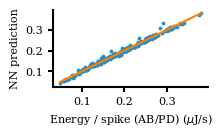

In [21]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()/1000
    unnorm_y = predictions[:300]/1000
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike (LP) ($\mu$J/s)")
    ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(3.8349)


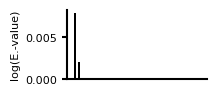

In [90]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_e_per_spike), dims=(0,)),
        figsize=(1.8, 0.9),
        ylabel="log(E.-value)",
        color="k",
        title=None,
        xlabel=False
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_supp_LP_EV1, facecolor="None", transparent=False)
    plt.show()

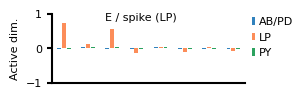

In [78]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        deepcopy(e_vecs_e_per_spike[:, -1].T),
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dim.",
        plot_labels=False,
        legend=True,
        title='E / spike (LP)',
        title_x_offset=-0.6,
        legend_y_offset=0.3,
    )
    plt.savefig(PANEL_supp_LP1, facecolor="None", transparent=True)
    plt.show()

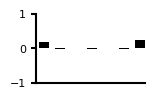

In [91]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_e_per_spike[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None, plot_labels=False
    )
    plt.savefig(PANEL_supp_LP_syn1, facecolor="None", transparent=False)
    plt.show()

## Number of spikes

In [81]:
numSpikesPerBurst = x["num_spikes"]["LP"].to_numpy() / x["num_bursts"]["LP"].to_numpy()
numSpikesPerBurst_test = torch.as_tensor(
    numSpikesPerBurst[:num_test], dtype=torch.float32
).unsqueeze(1)
numSpikesPerBurst_train = torch.as_tensor(
    numSpikesPerBurst[num_test:], dtype=torch.float32
).unsqueeze(1)

In [82]:
torch.manual_seed(0)

sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_num_spikes = sensitivity_num_spikes.add_property(
    theta_train,
    numSpikesPerBurst_train,
    hidden_features=20,
    num_blocks=1
).train()
e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_active()

In [83]:
predictions = converged_nn_num_spikes(theta_test).detach().numpy()

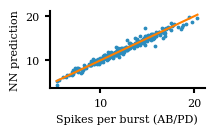

In [84]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = numSpikesPerBurst_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst (AB/PD)")
    ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(35.0191)


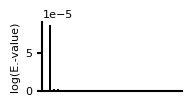

In [92]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_num_spikes), dims=(0,)),
        figsize=(1.8, 0.9),
        ylabel="log(E.-value)",
        color="k",
        title=None,
        xlabel=False
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
    )
    plt.savefig(PANEL_supp_LP_EV2, facecolor="None", transparent=False)
    plt.show()

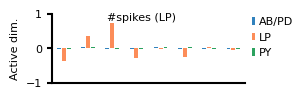

In [94]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs_num_spikes[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dim.",
        plot_labels=False,
        legend=True,
        legend_y_offset=0.3,
        title='#spikes (LP)',
        title_x_offset=-0.5,
    )
    plt.savefig(PANEL_supp_LP2, facecolor="None", transparent=True)
    plt.show()

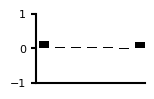

In [93]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_num_spikes[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None, plot_labels=False
    )
    plt.savefig(PANEL_supp_LP_syn2, facecolor="None", transparent=False)
    plt.show()

# Relationship between the two

In [33]:
projected_e_per_spike = sensitivity_e_per_spike.project(theta_train, num_dimensions=1)
projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

In [34]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
# ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 0)
# ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [35]:
cond1 = projected_e_per_spike > -1.0
cond2 = projected_e_per_spike < -0.8
cond3 = projected_num_spikes > -0.7
cond4 = projected_num_spikes < -0.6

In [36]:
full_cond = torch.logical_and(
    torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4
)

In [37]:
fulfiling_param_sets = theta_train[full_cond[:, 0]]
print(fulfiling_param_sets.shape)

torch.Size([197, 31])


In [38]:
parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = sensitivity_e_per_spike.project(parameter_set1, num_dimensions=1)
parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = sensitivity_e_per_spike.project(parameter_set2, num_dimensions=1)
parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3 = theta_train[full_cond[:, 0]][2].unsqueeze(0)
parameter_set3_dim1 = sensitivity_e_per_spike.project(parameter_set3, num_dimensions=1)
parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

In [42]:
energy_PM = x["energies"]["LP"].to_numpy()
energy_PM_train = energy_PM[num_test:]

In [43]:
v1 = e_vecs_num_spikes[:, -1]
v2 = e_vecs_e_per_spike[:, -1]
norm_v1 = torch.norm(v1)
dot_prod = torch.dot(v1, v2).item()
angle = math.acos(dot_prod)
print("angle in rad:", angle)
print("angle in deg:", angle / 2 / math.pi * 360)

angle_within_90deg = math.pi - angle
my_ticker = ticker.FixedFormatter([-2, 0, 2])

angle in rad: 1.2287713901900716
angle in deg: 70.40341464431398


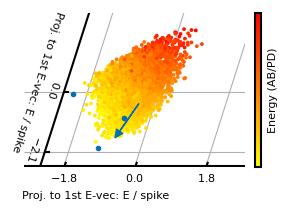

In [44]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.1, 2.0))
    viz.curvelinear_test1(
        fig,
        angle_within_90deg,
        projected_num_spikes,
        projected_e_per_spike,
        energy_PM_train,
        parameter_set1_dim1,
        parameter_set1_dim2,
        parameter_set2_dim1,
        parameter_set2_dim2,
        parameter_set3_dim1,
        parameter_set3_dim2,
    )
#     plt.savefig(PANEL_F1, facecolor="None", transparent=True)
    plt.show()

## Assemble figure

In [55]:
time_vec = np.arange(0, 11000, 0.025)

In [56]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [62]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "13.0cm",
    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(2.0*factor_svg, 1.0*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(2*factor_svg, 16.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_raw.svg")
svg('../fig/fig3_raw.svg')

### Build appendix

In [60]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.7cm",

    Panel(
          SVG(PANEL_supp_EV1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 2.1*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp2.svg")
svg('../fig/fig3_supp2.svg')

In [83]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.0cm",

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, -0.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp1.svg")
svg('../fig/fig3_supp1.svg')

In [84]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.8cm",

    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 2.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(28*factor_svg, 0.*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(53*factor_svg, 0.*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp3.svg")
svg('../fig/fig3_supp3.svg')